In [1]:
!pip install umap-learn
!pip install plotly
!pip install tensorflow
!pip install scikit-learn-extra

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 31.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_olivetti_faces, load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA, IncrementalPCA, FactorAnalysis
from sklearn.manifold import LocallyLinearEmbedding, TSNE, Isomap, MDS
import umap
import plotly.express as px
import plotly.graph_objects as go
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data
Faces dataset shape: (400, 4096)
Digits dataset shape: (1797, 64)


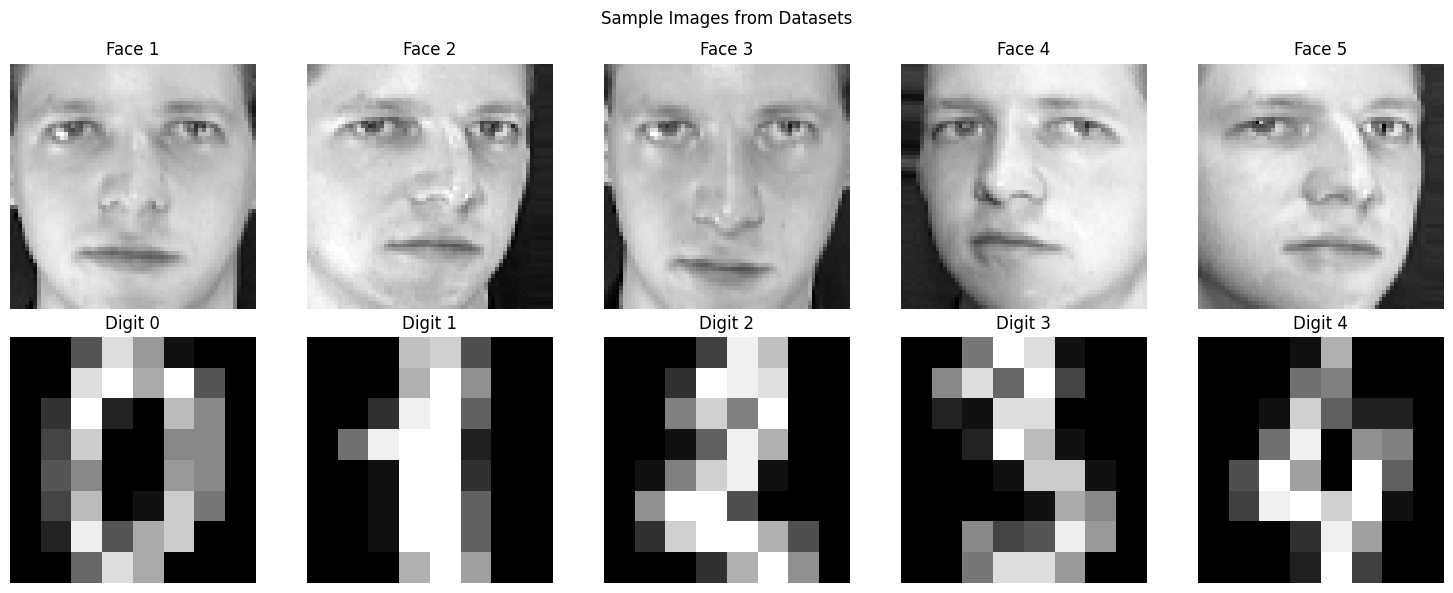

In [3]:
def load_and_prepare_data():
    # Load Olivetti faces dataset
    faces = fetch_olivetti_faces()
    X_faces = faces.data
    y_faces = faces.target

    # Load digits dataset
    digits = load_digits()
    X_digits = digits.data
    y_digits = digits.target

    # Standardize both datasets
    scaler = StandardScaler()
    X_faces_scaled = scaler.fit_transform(X_faces)
    X_digits_scaled = scaler.fit_transform(X_digits)

    return (X_faces_scaled, y_faces, X_faces), (X_digits_scaled, y_digits, X_digits)

# Load the data
(X_faces_scaled, y_faces, X_faces_orig), (X_digits_scaled, y_digits, X_digits_orig) = load_and_prepare_data()

# Print dataset information
print("Faces dataset shape:", X_faces_scaled.shape)
print("Digits dataset shape:", X_digits_scaled.shape)

# Visualize some examples
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Sample Images from Datasets')

# Plot faces
for i in range(5):
    axes[0, i].imshow(X_faces_orig[i].reshape(64, 64), cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Face {i+1}')

# Plot digits
for i in range(5):
    axes[1, i].imshow(X_digits_orig[i].reshape(8, 8), cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title(f'Digit {y_digits[i]}')

plt.tight_layout()
plt.show()

In [4]:
def plot_2d_embedding(X_embedded, y, title, interactive=False):
    if not interactive:
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1],
                            c=y, cmap='Spectral')
        plt.colorbar(scatter)
        plt.title(title)
        plt.show()
    else:
        fig = px.scatter(x=X_embedded[:, 0], y=X_embedded[:, 1],
                        color=y.astype(str),
                        title=title,
                        labels={'x': 'First component',
                               'y': 'Second component'},
                        template='plotly_white')
        fig.show()

Applying LLE... (input shape: (400, 4096))
Applying LLE... (input shape: (1797, 64))


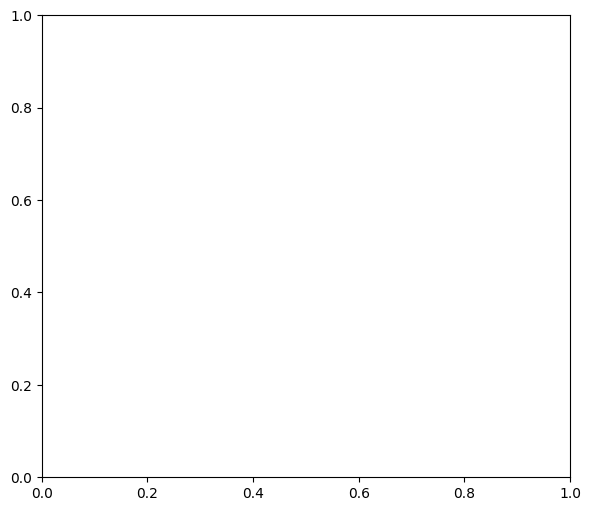

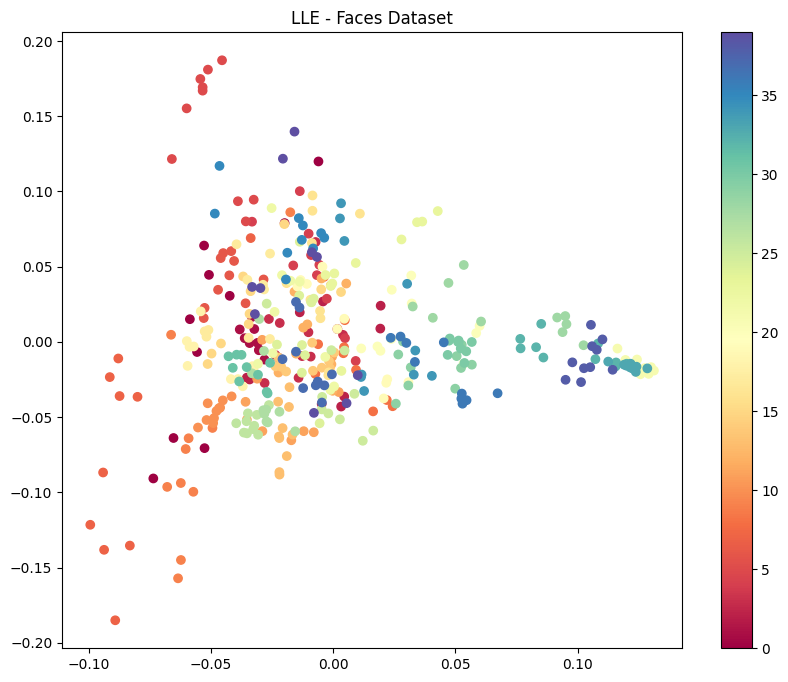

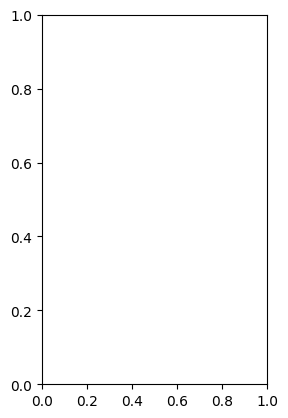

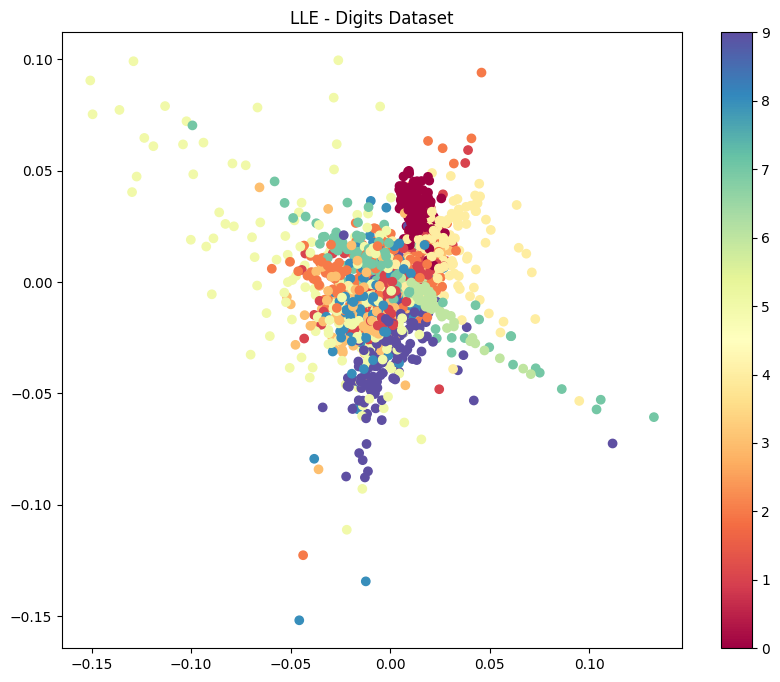

<Figure size 640x480 with 0 Axes>

In [6]:
def apply_lle(X, n_components=2, n_neighbors=30):
    lle = LocallyLinearEmbedding(n_components=n_components,
                                n_neighbors=n_neighbors,
                                random_state=42)
    print(f"Applying LLE... (input shape: {X.shape})")
    X_lle = lle.fit_transform(X)
    return X_lle

# Apply LLE to both datasets
X_faces_lle = apply_lle(X_faces_scaled)
X_digits_lle = apply_lle(X_digits_scaled)

# Visualize LLE results
plt.figure(figsize=(15, 6))

plt.subplot(121)
plot_2d_embedding(X_faces_lle, y_faces, 'LLE - Faces Dataset')

plt.subplot(122)
plot_2d_embedding(X_digits_lle, y_digits, 'LLE - Digits Dataset')

plt.tight_layout()
plt.show()

Applying t-SNE... (input shape: (400, 4096))
Applying t-SNE... (input shape: (1797, 64))


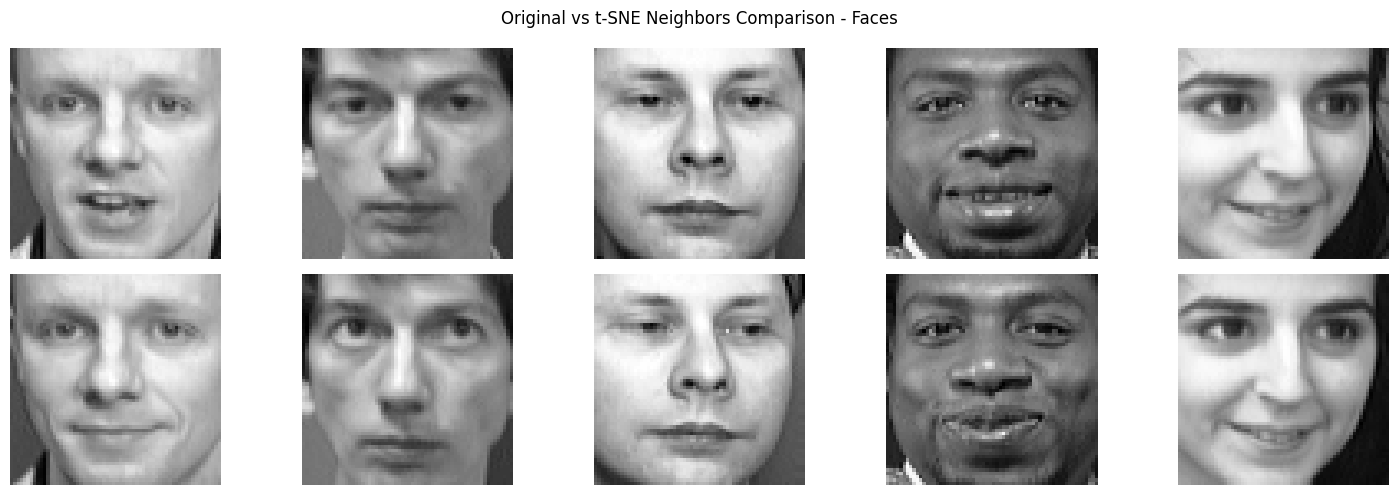

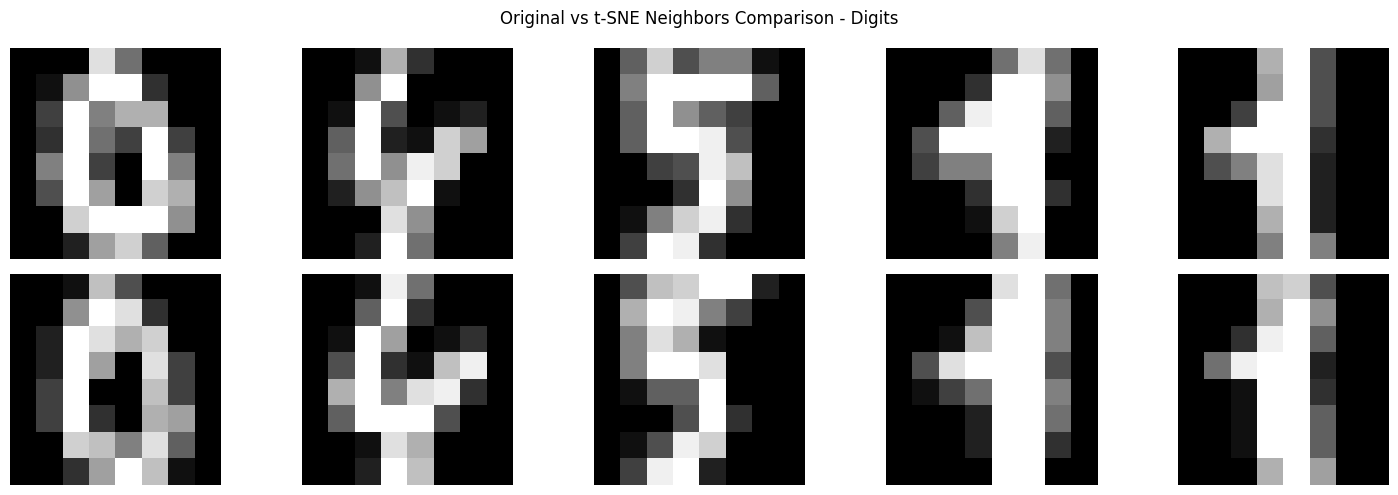

In [7]:
def apply_tsne(X, perplexity=30):
    print(f"Applying t-SNE... (input shape: {X.shape})")
    tsne = TSNE(n_components=2,
                perplexity=perplexity,
                random_state=42)
    X_tsne = tsne.fit_transform(X)
    return X_tsne

# Apply t-SNE to both datasets
X_faces_tsne = apply_tsne(X_faces_scaled)
X_digits_tsne = apply_tsne(X_digits_scaled)

# Create interactive visualizations using plotly
# For Faces dataset
plot_2d_embedding(X_faces_tsne, y_faces, 't-SNE - Faces Dataset', interactive=True)

# For Digits dataset
plot_2d_embedding(X_digits_tsne, y_digits, 't-SNE - Digits Dataset', interactive=True)

# Let's also add a function to examine the preservation of local structure
def plot_original_vs_embedded(X_orig, X_embedded, indices, n_samples=5, dataset_type="faces"):
    fig, axes = plt.subplots(2, n_samples, figsize=(15, 5))
    fig.suptitle(f'Original vs t-SNE Neighbors Comparison - {dataset_type.capitalize()}')

    if dataset_type == "faces":
        reshape_dim = (64, 64)
    else:
        reshape_dim = (8, 8)

    for i in range(n_samples):
        # Plot original image
        axes[0, i].imshow(X_orig[indices[i]].reshape(reshape_dim), cmap='gray')
        axes[0, i].axis('off')

        # Find nearest neighbor in embedded space
        distances = np.linalg.norm(X_embedded - X_embedded[indices[i]], axis=1)
        nearest_idx = np.argsort(distances)[1]  # [0] would be the point itself

        # Plot nearest neighbor
        axes[1, i].imshow(X_orig[nearest_idx].reshape(reshape_dim), cmap='gray')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize some random samples and their nearest neighbors
random_indices = np.random.choice(len(X_faces_orig), 5, replace=False)
plot_original_vs_embedded(X_faces_orig, X_faces_tsne, random_indices, dataset_type="faces")
plot_original_vs_embedded(X_digits_orig, X_digits_tsne, random_indices, dataset_type="digits")

Applying ISOMAP... (input shape: (400, 4096))
Applying ISOMAP... (input shape: (1797, 64))


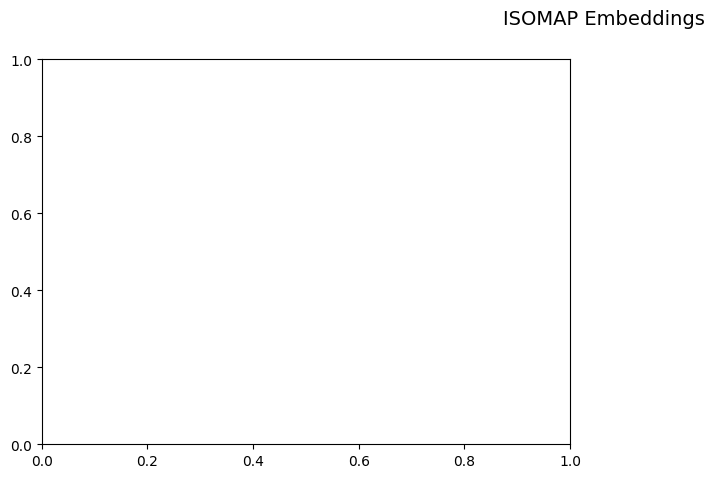

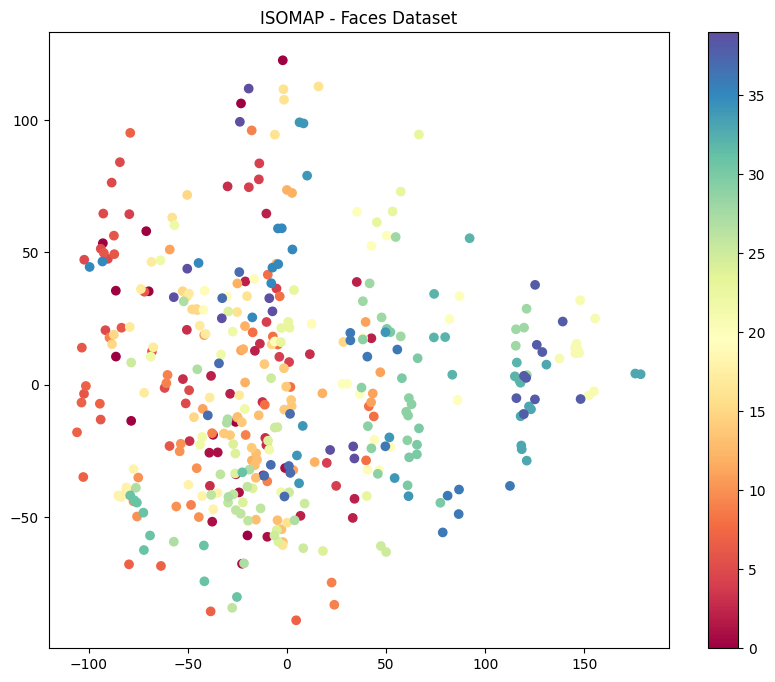

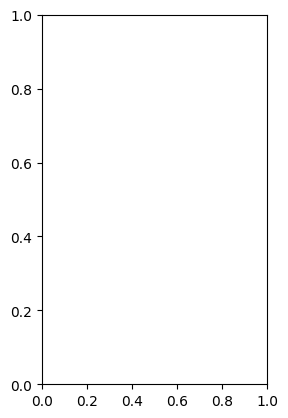

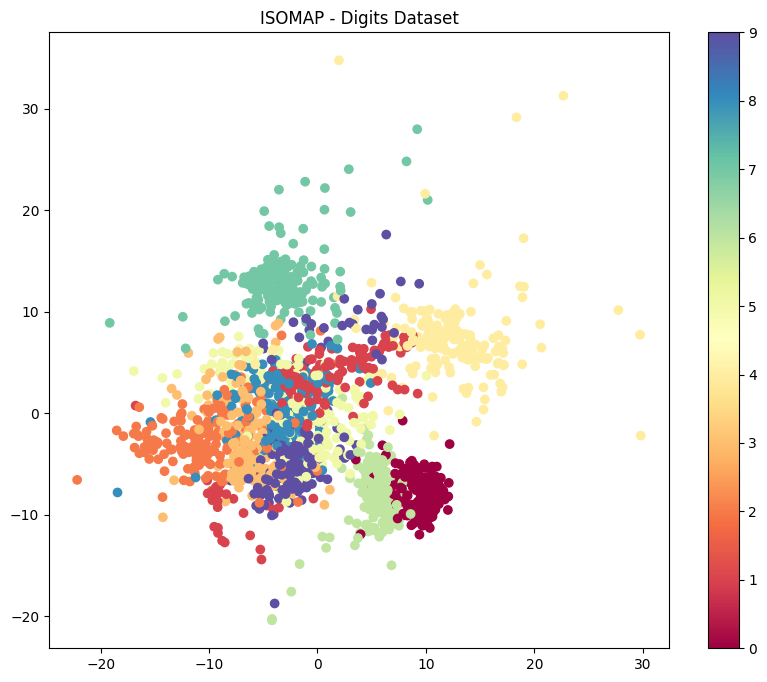

<Figure size 640x480 with 0 Axes>

In [8]:
def apply_isomap(X, n_neighbors=30):
    print(f"Applying ISOMAP... (input shape: {X.shape})")
    isomap = Isomap(n_components=2,
                    n_neighbors=n_neighbors)
    X_isomap = isomap.fit_transform(X)
    return X_isomap

# Apply ISOMAP to both datasets
X_faces_isomap = apply_isomap(X_faces_scaled)
X_digits_isomap = apply_isomap(X_digits_scaled)

# Create interactive visualizations for ISOMAP
plt.figure(figsize=(15, 5))
plt.suptitle('ISOMAP Embeddings', fontsize=14)

plt.subplot(121)
plot_2d_embedding(X_faces_isomap, y_faces, 'ISOMAP - Faces Dataset')

plt.subplot(122)
plot_2d_embedding(X_digits_isomap, y_digits, 'ISOMAP - Digits Dataset')

plt.tight_layout()
plt.show()

# Interactive visualization
plot_2d_embedding(X_faces_isomap, y_faces, 'ISOMAP - Faces Dataset (Interactive)', interactive=True)
plot_2d_embedding(X_digits_isomap, y_digits, 'ISOMAP - Digits Dataset (Interactive)', interactive=True)

In [10]:
def apply_umap(X, n_neighbors=15, min_dist=0.1):
    print(f"Applying UMAP... (input shape: {X.shape})")
    reducer = umap.UMAP(n_neighbors=n_neighbors,
                       min_dist=min_dist,
                       random_state=42)
    X_umap = reducer.fit_transform(X)
    return X_umap, reducer

# Apply UMAP to both datasets
X_faces_umap, faces_umap_model = apply_umap(X_faces_scaled)
X_digits_umap, digits_umap_model = apply_umap(X_digits_scaled)

# Create interactive visualization with plotly
def create_interactive_umap_plot(X_embedded, y, title, original_images=None):
    # Create a DataFrame for plotly
    df = pd.DataFrame({
        'UMAP1': X_embedded[:, 0],
        'UMAP2': X_embedded[:, 1],
        'Label': y.astype(str)
    })

    fig = px.scatter(df, x='UMAP1', y='UMAP2',
                    color='Label',
                    title=title,
                    template='plotly_white',
                    hover_data=['Label'])

    # Add custom hover template if original images are provided
    if original_images is not None:
        fig.update_traces(
            hovertemplate="<br>".join([
                "UMAP1: %{x}",
                "UMAP2: %{y}",
                "Label: %{customdata[0]}",
            ])
        )

    fig.update_layout(
        width=800,
        height=600,
        updatemenus=[{
            'buttons': [
                {'args': [{'marker.size': 6}],
                 'label': 'Small Points',
                 'method': 'restyle'},
                {'args': [{'marker.size': 10}],
                 'label': 'Medium Points',
                 'method': 'restyle'},
                {'args': [{'marker.size': 15}],
                 'label': 'Large Points',
                 'method': 'restyle'}
            ],
            'direction': 'down',
            'showactive': True,
            'x': 0.1,
            'y': 1.1
        }]
    )

    return fig

# Create and display interactive plots
faces_umap_fig = create_interactive_umap_plot(X_faces_umap, y_faces,
                                            'UMAP - Faces Dataset (Interactive)',
                                            X_faces_orig)
digits_umap_fig = create_interactive_umap_plot(X_digits_umap, y_digits,
                                             'UMAP - Digits Dataset (Interactive)',
                                             X_digits_orig)
faces_umap_fig.show()
digits_umap_fig.show()

# Add comparison of clustering quality
from sklearn.metrics import silhouette_score

methods = {
    'ISOMAP': {'faces': X_faces_isomap, 'digits': X_digits_isomap},
    'UMAP': {'faces': X_faces_umap, 'digits': X_digits_umap}
}

print("\nSilhouette Scores Comparison:")
for method_name, embeddings in methods.items():
    for dataset_name, embedding in embeddings.items():
        score = silhouette_score(embedding, eval(f"y_{dataset_name}"))
        print(f"{method_name} - {dataset_name}: {score:.3f}")

Applying UMAP... (input shape: (400, 4096))
Applying UMAP... (input shape: (1797, 64))



Silhouette Scores Comparison:
ISOMAP - faces: -0.253
ISOMAP - digits: 0.158
UMAP - faces: 0.135
UMAP - digits: 0.595


Applying Metric MDS... (input shape: (400, 4096))
Time elapsed: 1.07 seconds
Applying Metric MDS... (input shape: (1797, 64))
Time elapsed: 32.41 seconds
Applying Non-metric MDS... (input shape: (400, 4096))
Time elapsed: 0.26 seconds
Applying Non-metric MDS... (input shape: (1797, 64))
Time elapsed: 3.84 seconds


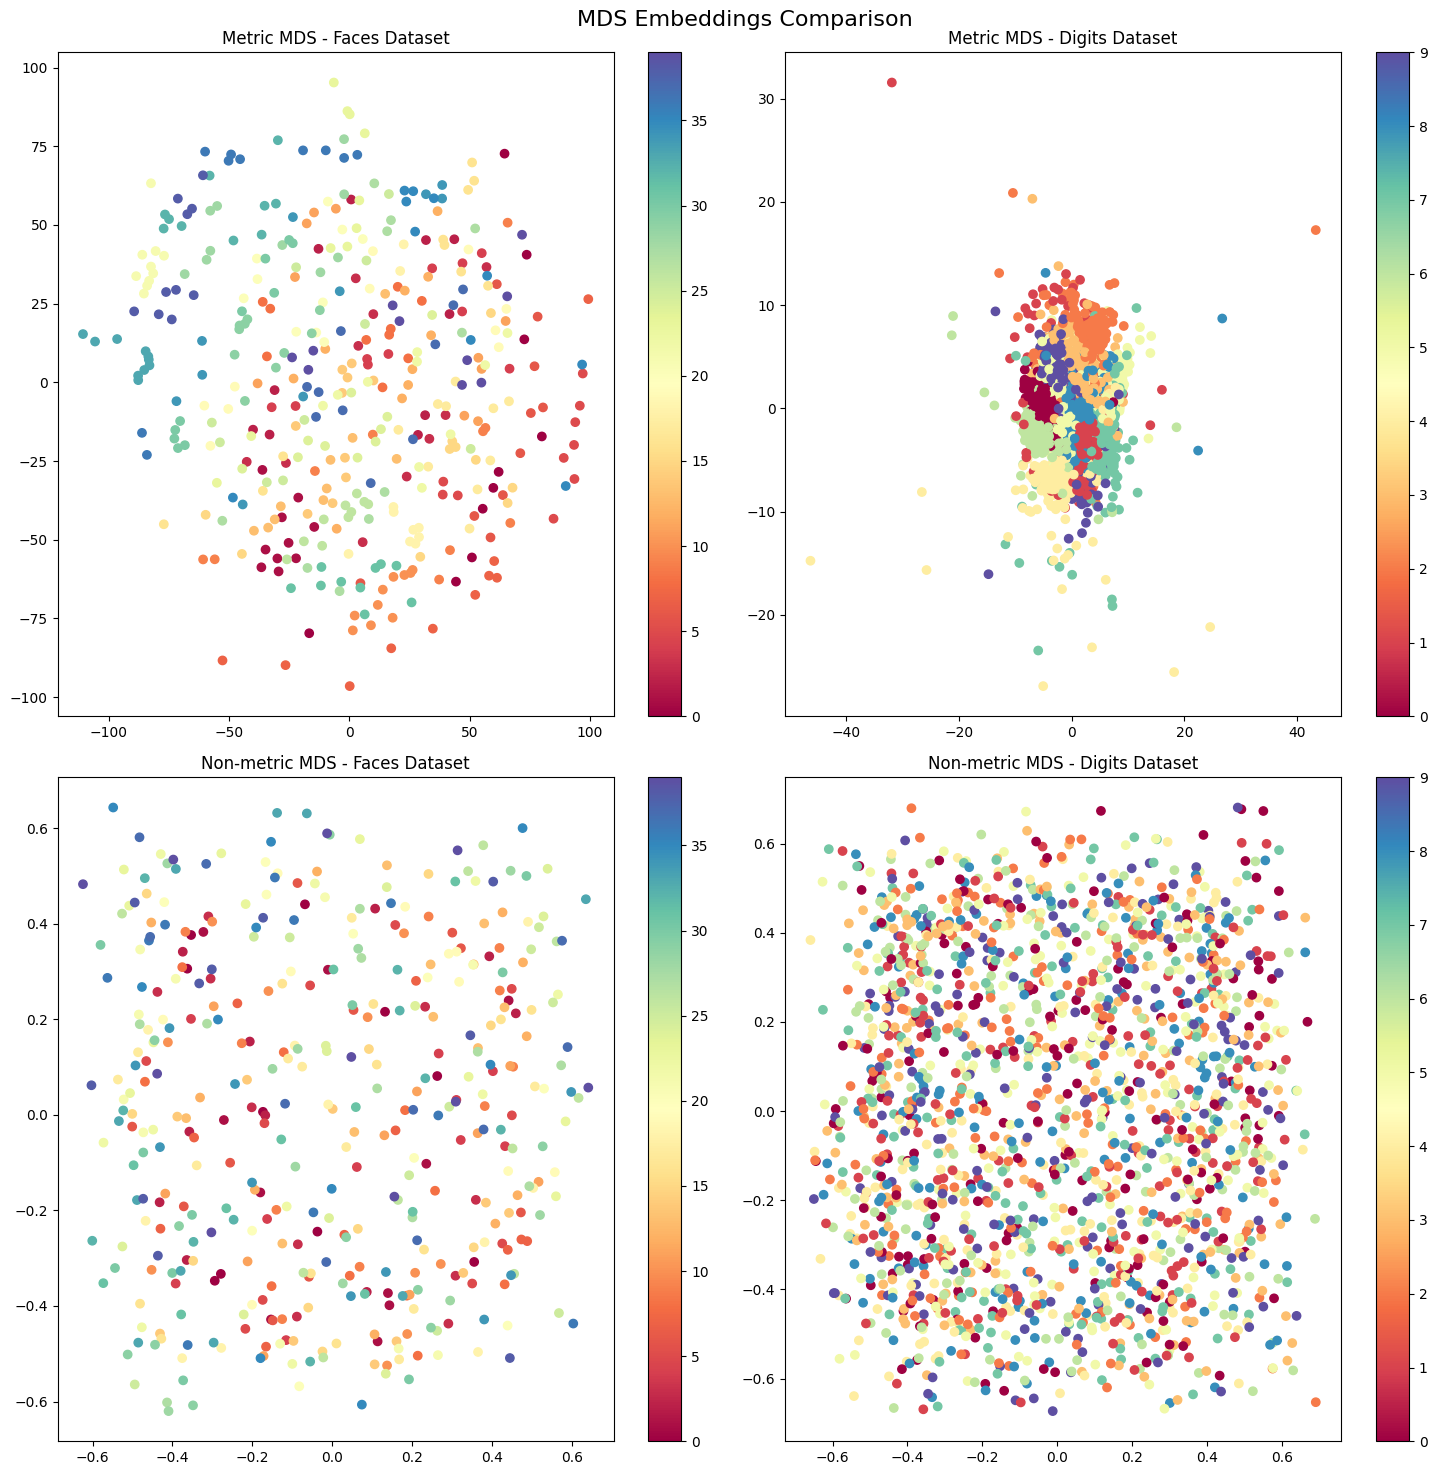

In [11]:
from sklearn.manifold import MDS
from time import time

def apply_mds(X, n_components=2, metric=True):
    print(f"Applying {'Metric' if metric else 'Non-metric'} MDS... (input shape: {X.shape})")
    t0 = time()

    mds = MDS(n_components=n_components,
              metric=metric,
              n_init=1,
              random_state=42)
    X_mds = mds.fit_transform(X)

    print(f"Time elapsed: {time() - t0:.2f} seconds")
    return X_mds

# Apply both metric and non-metric MDS to the datasets
X_faces_mds_metric = apply_mds(X_faces_scaled, metric=True)
X_digits_mds_metric = apply_mds(X_digits_scaled, metric=True)
X_faces_mds_nonmetric = apply_mds(X_faces_scaled, metric=False)
X_digits_mds_nonmetric = apply_mds(X_digits_scaled, metric=False)

# Create visualization grid
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
fig.suptitle('MDS Embeddings Comparison', fontsize=16)

# Plot metric MDS results
scatter1 = axes[0,0].scatter(X_faces_mds_metric[:, 0], X_faces_mds_metric[:, 1],
                            c=y_faces, cmap='Spectral')
axes[0,0].set_title('Metric MDS - Faces Dataset')
plt.colorbar(scatter1, ax=axes[0,0])

scatter2 = axes[0,1].scatter(X_digits_mds_metric[:, 0], X_digits_mds_metric[:, 1],
                            c=y_digits, cmap='Spectral')
axes[0,1].set_title('Metric MDS - Digits Dataset')
plt.colorbar(scatter2, ax=axes[0,1])

# Plot non-metric MDS results
scatter3 = axes[1,0].scatter(X_faces_mds_nonmetric[:, 0], X_faces_mds_nonmetric[:, 1],
                            c=y_faces, cmap='Spectral')
axes[1,0].set_title('Non-metric MDS - Faces Dataset')
plt.colorbar(scatter3, ax=axes[1,0])

scatter4 = axes[1,1].scatter(X_digits_mds_nonmetric[:, 0], X_digits_mds_nonmetric[:, 1],
                            c=y_digits, cmap='Spectral')
axes[1,1].set_title('Non-metric MDS - Digits Dataset')
plt.colorbar(scatter4, ax=axes[1,1])

plt.tight_layout()
plt.show()

Applying Randomized PCA... (input shape: (400, 4096))
Time elapsed: 0.23 seconds
Explained variance ratio: 0.392
Applying Randomized PCA... (input shape: (1797, 64))
Time elapsed: 0.02 seconds
Explained variance ratio: 0.216


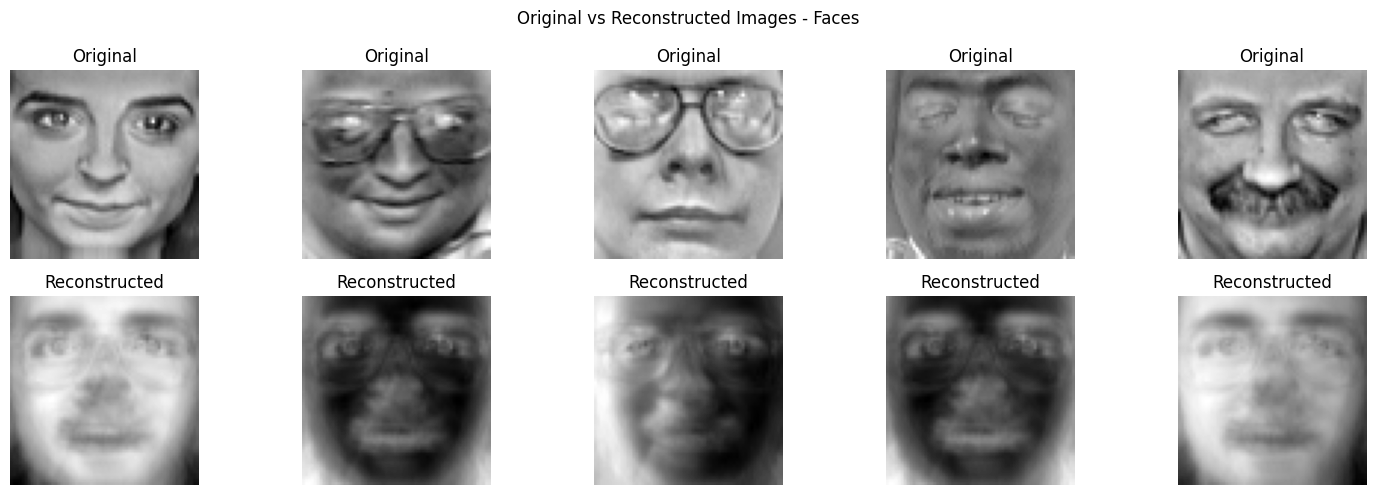

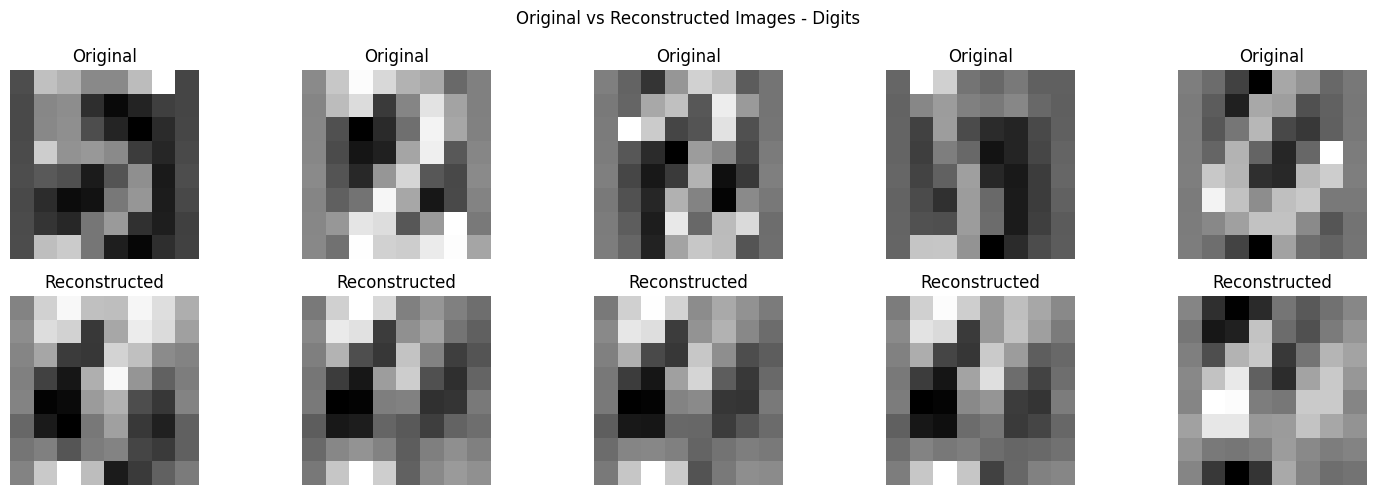

In [12]:
from sklearn.decomposition import PCA

def apply_randomized_pca(X, n_components=2):
    print(f"Applying Randomized PCA... (input shape: {X.shape})")
    t0 = time()

    rpca = PCA(n_components=n_components,
               svd_solver='randomized',
               random_state=42)
    X_rpca = rpca.fit_transform(X)

    print(f"Time elapsed: {time() - t0:.2f} seconds")
    print(f"Explained variance ratio: {rpca.explained_variance_ratio_.sum():.3f}")
    return X_rpca, rpca

# Apply Randomized PCA to both datasets
X_faces_rpca, faces_rpca_model = apply_randomized_pca(X_faces_scaled)
X_digits_rpca, digits_rpca_model = apply_randomized_pca(X_digits_scaled)

# Create interactive visualization for Randomized PCA
def plot_rpca_results(X_rpca, y, title, model):
    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Add scatter plot
    scatter = go.Scatter(x=X_rpca[:, 0], y=X_rpca[:, 1],
                        mode='markers',
                        marker=dict(color=y,
                                  colorscale='Spectral',
                                  showscale=True),
                        name='Data points')
    fig.add_trace(scatter)

    # Add cumulative explained variance
    cum_var_ratio = np.cumsum(model.explained_variance_ratio_)
    var_trace = go.Scatter(x=list(range(1, len(cum_var_ratio) + 1)),
                          y=cum_var_ratio,
                          name='Cumulative Explained Variance',
                          line=dict(color='red'),
                          yaxis='y2')
    fig.add_trace(var_trace, secondary_y=True)

    # Update layout
    fig.update_layout(
        title=title,
        xaxis_title="First Principal Component",
        yaxis_title="Second Principal Component",
        yaxis2_title="Cumulative Explained Variance",
        height=600,
        width=800,
        showlegend=True
    )

    return fig

# Plot interactive visualizations
from plotly.subplots import make_subplots
faces_rpca_fig = plot_rpca_results(X_faces_rpca, y_faces,
                                  'Randomized PCA - Faces Dataset',
                                  faces_rpca_model)
digits_rpca_fig = plot_rpca_results(X_digits_rpca, y_digits,
                                   'Randomized PCA - Digits Dataset',
                                   digits_rpca_model)

faces_rpca_fig.show()
digits_rpca_fig.show()

# Compare reconstruction quality
def plot_reconstruction(X_orig, model, n_samples=5, dataset_type="faces"):
    if dataset_type == "faces":
        reshape_dim = (64, 64)
    else:
        reshape_dim = (8, 8)

    fig, axes = plt.subplots(2, n_samples, figsize=(15, 5))
    fig.suptitle(f'Original vs Reconstructed Images - {dataset_type.capitalize()}')

    # Randomly select samples
    indices = np.random.choice(len(X_orig), n_samples, replace=False)

    for i, idx in enumerate(indices):
        # Original image
        axes[0, i].imshow(X_orig[idx].reshape(reshape_dim), cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title('Original')

        # Reconstructed image
        X_reconstructed = model.inverse_transform(model.transform([X_orig[idx]]))
        axes[1, i].imshow(X_reconstructed.reshape(reshape_dim), cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title('Reconstructed')

    plt.tight_layout()
    plt.show()

# Plot reconstructions
plot_reconstruction(X_faces_scaled, faces_rpca_model, dataset_type="faces")
plot_reconstruction(X_digits_scaled, digits_rpca_model, dataset_type="digits")

In [13]:
from sklearn.decomposition import KernelPCA

def apply_kernel_pca(X, kernel='rbf', gamma=None):
    print(f"Applying Kernel PCA with {kernel} kernel... (input shape: {X.shape})")
    t0 = time()

    kpca = KernelPCA(n_components=2,
                     kernel=kernel,
                     gamma=gamma,
                     random_state=42)
    X_kpca = kpca.fit_transform(X)

    print(f"Time elapsed: {time() - t0:.2f} seconds")
    return X_kpca, kpca

# Apply different kernel PCAs
kernels = ['rbf', 'poly', 'sigmoid']
faces_kpca_results = {}
digits_kpca_results = {}

for kernel in kernels:
    faces_kpca_results[kernel] = apply_kernel_pca(X_faces_scaled, kernel=kernel)
    digits_kpca_results[kernel] = apply_kernel_pca(X_digits_scaled, kernel=kernel)

# Create interactive visualization for kernel comparison
def create_kernel_comparison_plot(kpca_results, y, title_prefix):
    fig = go.Figure()

    for kernel in kernels:
        X_kpca = kpca_results[kernel][0]

        fig.add_trace(go.Scatter(
            visible=False,
            x=X_kpca[:, 0],
            y=X_kpca[:, 1],
            mode='markers',
            marker=dict(
                color=y,
                colorscale='Spectral',
                showscale=True
            ),
            name=f'{kernel} kernel'
        ))

    # Make first kernel visible
    fig.data[0].visible = True

    # Create buttons for kernel selection
    steps = []
    for i in range(len(kernels)):
        step = dict(
            method="update",
            args=[{"visible": [False] * len(kernels)},
                  {"title": f"{title_prefix} - {kernels[i].upper()} Kernel"}],
            label=kernels[i].upper()
        )
        step["args"][0]["visible"][i] = True
        steps.append(step)

    sliders = [dict(
        active=0,
        currentvalue={"prefix": "Kernel: "},
        pad={"t": 50},
        steps=steps
    )]

    fig.update_layout(
        title=f"{title_prefix} - {kernels[0].upper()} Kernel",
        sliders=sliders,
        width=800,
        height=600
    )

    return fig

# Display interactive kernel comparison plots
faces_kpca_fig = create_kernel_comparison_plot(faces_kpca_results, y_faces,
                                             'Kernel PCA - Faces Dataset')
digits_kpca_fig = create_kernel_comparison_plot(digits_kpca_results, y_digits,
                                              'Kernel PCA - Digits Dataset')

faces_kpca_fig.show()
digits_kpca_fig.show()

Applying Kernel PCA with rbf kernel... (input shape: (400, 4096))
Time elapsed: 0.10 seconds
Applying Kernel PCA with rbf kernel... (input shape: (1797, 64))
Time elapsed: 0.28 seconds
Applying Kernel PCA with poly kernel... (input shape: (400, 4096))
Time elapsed: 0.05 seconds
Applying Kernel PCA with poly kernel... (input shape: (1797, 64))
Time elapsed: 0.17 seconds
Applying Kernel PCA with sigmoid kernel... (input shape: (400, 4096))
Time elapsed: 0.05 seconds
Applying Kernel PCA with sigmoid kernel... (input shape: (1797, 64))
Time elapsed: 0.21 seconds


In [14]:
 def apply_incremental_pca(X, n_components=2, batch_size=50):
    print(f"Applying Incremental PCA... (input shape: {X.shape})")
    t0 = time()

    # Initialize Incremental PCA
    ipca = IncrementalPCA(n_components=n_components)

    # Process data in batches
    for i in range(0, len(X), batch_size):
        ipca.partial_fit(X[i:i + batch_size])

    # Transform the entire dataset
    X_ipca = ipca.transform(X)

    print(f"Time elapsed: {time() - t0:.2f} seconds")
    print(f"Explained variance ratio: {ipca.explained_variance_ratio_.sum():.3f}")
    return X_ipca, ipca

# Apply Incremental PCA to both datasets
X_faces_ipca, faces_ipca_model = apply_incremental_pca(X_faces_scaled)
X_digits_ipca, digits_ipca_model = apply_incremental_pca(X_digits_scaled)

# Create comparison visualization between regular PCA and Incremental PCA
def compare_pca_methods(X_rpca, X_ipca, y, title):
    fig = make_subplots(rows=1, cols=2,
                       subplot_titles=('Randomized PCA', 'Incremental PCA'))

    # Add Randomized PCA scatter
    fig.add_trace(
        go.Scatter(x=X_rpca[:, 0], y=X_rpca[:, 1],
                  mode='markers',
                  marker=dict(color=y,
                            colorscale='Spectral',
                            showscale=True),
                  name='Randomized PCA'),
        row=1, col=1
    )

    # Add Incremental PCA scatter
    fig.add_trace(
        go.Scatter(x=X_ipca[:, 0], y=X_ipca[:, 1],
                  mode='markers',
                  marker=dict(color=y,
                            colorscale='Spectral',
                            showscale=True),
                  name='Incremental PCA'),
        row=1, col=2
    )

    fig.update_layout(
        title=title,
        height=500,
        width=1000,
        showlegend=True
    )

    return fig

# Create and display comparison plots
faces_pca_comparison = compare_pca_methods(X_faces_rpca, X_faces_ipca, y_faces,
                                         'PCA Methods Comparison - Faces Dataset')
digits_pca_comparison = compare_pca_methods(X_digits_rpca, X_digits_ipca, y_digits,
                                          'PCA Methods Comparison - Digits Dataset')

faces_pca_comparison.show()
digits_pca_comparison.show()

# Compare memory usage and processing time
def print_performance_metrics(X, batch_size=50):
    print("\nPerformance Comparison:")
    print("-" * 50)

    # Memory usage estimation
    full_data_size = X.nbytes / (1024 * 1024)  # in MB
    batch_size_mb = (X[:batch_size].nbytes) / (1024 * 1024)  # in MB

    print(f"Full dataset size: {full_data_size:.2f} MB")
    print(f"Batch size: {batch_size_mb:.2f} MB")

    # Processing time comparison
    t0 = time()
    pca = PCA(n_components=2, svd_solver='randomized', random_state=42)
    pca.fit_transform(X)
    randomized_time = time() - t0

    t0 = time()
    ipca = IncrementalPCA(n_components=2)
    for i in range(0, len(X), batch_size):
        ipca.partial_fit(X[i:i + batch_size])
    ipca.transform(X)
    incremental_time = time() - t0

    print(f"\nProcessing times:")
    print(f"Randomized PCA: {randomized_time:.2f} seconds")
    print(f"Incremental PCA: {incremental_time:.2f} seconds")

# Print performance metrics for both datasets
print("\nFaces Dataset:")
print_performance_metrics(X_faces_scaled)

print("\nDigits Dataset:")
print_performance_metrics(X_digits_scaled)

Applying Incremental PCA... (input shape: (400, 4096))
Time elapsed: 0.46 seconds
Explained variance ratio: 0.380
Applying Incremental PCA... (input shape: (1797, 64))
Time elapsed: 0.17 seconds
Explained variance ratio: 0.147



Faces Dataset:

Performance Comparison:
--------------------------------------------------
Full dataset size: 6.25 MB
Batch size: 0.78 MB

Processing times:
Randomized PCA: 0.27 seconds
Incremental PCA: 4.27 seconds

Digits Dataset:

Performance Comparison:
--------------------------------------------------
Full dataset size: 0.88 MB
Batch size: 0.02 MB

Processing times:
Randomized PCA: 0.09 seconds
Incremental PCA: 0.19 seconds


In [15]:
from sklearn.decomposition import FactorAnalysis

def apply_factor_analysis(X, n_components=2):
    print(f"Applying Factor Analysis... (input shape: {X.shape})")
    t0 = time()

    fa = FactorAnalysis(n_components=n_components,
                       random_state=42)
    X_fa = fa.fit_transform(X)

    print(f"Time elapsed: {time() - t0:.2f} seconds")
    return X_fa, fa

# Apply Factor Analysis to both datasets
X_faces_fa, faces_fa_model = apply_factor_analysis(X_faces_scaled)
X_digits_fa, digits_fa_model = apply_factor_analysis(X_digits_scaled)

# Create interactive visualization comparing FA with PCA
def create_fa_pca_comparison(X_fa, X_pca, y, title):
    fig = make_subplots(rows=1, cols=2,
                       subplot_titles=('Factor Analysis', 'PCA'),
                       specs=[[{"type": "scatter"}, {"type": "scatter"}]])

    # Add Factor Analysis scatter
    fig.add_trace(
        go.Scatter(x=X_fa[:, 0], y=X_fa[:, 1],
                  mode='markers',
                  marker=dict(color=y,
                            colorscale='Spectral',
                            showscale=True),
                  name='Factor Analysis'),
        row=1, col=1
    )

    # Add PCA scatter
    fig.add_trace(
        go.Scatter(x=X_pca[:, 0], y=X_pca[:, 1],
                  mode='markers',
                  marker=dict(color=y,
                            colorscale='Spectral',
                            showscale=True),
                  name='PCA'),
        row=1, col=2
    )

    fig.update_layout(
        title=title,
        height=500,
        width=1000,
        showlegend=True
    )

    return fig

# Create and display comparison plots
faces_fa_comparison = create_fa_pca_comparison(X_faces_fa, X_faces_rpca, y_faces,
                                             'Factor Analysis vs PCA - Faces Dataset')
digits_fa_comparison = create_fa_pca_comparison(X_digits_fa, X_digits_rpca, y_digits,
                                              'Factor Analysis vs PCA - Digits Dataset')

faces_fa_comparison.show()
digits_fa_comparison.show()

Applying Factor Analysis... (input shape: (400, 4096))
Time elapsed: 1.89 seconds
Applying Factor Analysis... (input shape: (1797, 64))
Time elapsed: 0.47 seconds


In [16]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping

class Autoencoder(Model):
    def __init__(self, input_dim, latent_dim=2):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.Dense(128, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(latent_dim, name="latent_space")
        ])

        # Decoder
        self.decoder = tf.keras.Sequential([
            layers.Dense(32, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(input_dim, activation='sigmoid')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

def train_autoencoder(X, input_dim, epochs=50, batch_size=32):
    print(f"Training Autoencoder... (input shape: {X.shape})")
    t0 = time()

    # Create and compile the model
    autoencoder = Autoencoder(input_dim)
    autoencoder.compile(optimizer='adam', loss='mse')

    # Early stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    # Train the model
    history = autoencoder.fit(
        X, X,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )

    print(f"Time elapsed: {time() - t0:.2f} seconds")
    return autoencoder, history

# Train autoencoders for both datasets
faces_autoencoder, faces_history = train_autoencoder(X_faces_scaled, X_faces_scaled.shape[1])
digits_autoencoder, digits_history = train_autoencoder(X_digits_scaled, X_digits_scaled.shape[1])

# Visualize training history
def plot_training_history(history, title):
    fig = go.Figure()

    # Add training loss
    fig.add_trace(go.Scatter(
        y=history.history['loss'],
        name='Training Loss',
        mode='lines',
        line=dict(color='blue')
    ))

    # Add validation loss
    fig.add_trace(go.Scatter(
        y=history.history['val_loss'],
        name='Validation Loss',
        mode='lines',
        line=dict(color='red')
    ))

    fig.update_layout(
        title=title,
        xaxis_title='Epoch',
        yaxis_title='Loss',
        width=800,
        height=400
    )

    return fig

# Plot training histories
faces_history_plot = plot_training_history(faces_history, 'Autoencoder Training History - Faces Dataset')
digits_history_plot = plot_training_history(digits_history, 'Autoencoder Training History - Digits Dataset')

faces_history_plot.show()
digits_history_plot.show()

# Visualize reconstructions and latent space
def visualize_autoencoder_results(X, y, autoencoder, dataset_type="faces"):
    # Get latent space representations
    latent_representations = autoencoder.encoder(X).numpy()
    reconstructions = autoencoder.decoder(latent_representations).numpy()

    # Create figure with subplots
    fig = make_subplots(rows=1, cols=2,
                       subplot_titles=('Latent Space', 'Sample Reconstructions'))

    # Plot latent space
    fig.add_trace(
        go.Scatter(
            x=latent_representations[:, 0],
            y=latent_representations[:, 1],
            mode='markers',
            marker=dict(color=y,
                       colorscale='Spectral',
                       showscale=True),
            name='Latent Space'
        ),
        row=1, col=1
    )

    # Update layout
    fig.update_layout(
        title=f'Autoencoder Results - {dataset_type} Dataset',
        height=500,
        width=1000,
        showlegend=True
    )

    fig.show()

    # Plot sample reconstructions
    n_samples = 5
    reshape_dim = (64, 64) if dataset_type == "faces" else (8, 8)

    plt.figure(figsize=(15, 3))
    for i in range(n_samples):
        # Original
        plt.subplot(2, n_samples, i + 1)
        plt.imshow(X[i].reshape(reshape_dim), cmap='gray')
        plt.axis('off')
        plt.title('Original')

        # Reconstruction
        plt.subplot(2, n_samples, i + n_samples + 1)
        plt.imshow(reconstructions[i].reshape(reshape_dim), cmap='gray')
        plt.axis('off')
        plt.title('Reconstructed')

    plt.tight_layout()
    plt.show()

# Visualize

Training Autoencoder... (input shape: (400, 4096))
Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step - loss: 1.1019 - val_loss: 1.3163
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8857 - val_loss: 1.2265
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8526 - val_loss: 1.2256
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8673 - val_loss: 1.2210
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8317 - val_loss: 1.2056
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7422 - val_loss: 1.2005
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7331 - val_loss: 1.2038
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7507 - val_loss: 1.2025
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7437 - val_loss: 1.2001
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7165 - val_loss: 1.1992
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7021 - val_loss: 1.1992
Epoch 12/50
10/10 ━━━